In [104]:
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

### 1. Carga de datos

In [105]:
def load_data(filepath):

    data = pd.read_csv(filepath)
    data["Date"] = pd.to_datetime(data["Date"])
    
    return data

### 2. Division y tratamiento de datos

In [106]:
def prepare_data(data, target_column, n_steps):
    
    # Remover las columnas que no son características
    features = data.drop(columns=['Date', target_column, 'LMCADY_std_5d_log'])

    # print(features.columns)
    
    # Estandarización del conjunto de datos
    # scaler = MinMaxScaler()
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # print(features_scaled.shape)
    # print(features_scaled)
    
    # Crear secuencias
    X, y = [], []
    for i in range(n_steps, len(data)):
        # Agregar la ventana de características anteriores
        X.append(features_scaled[i-n_steps:i])
        # Agregar el valor objetivo
        y.append(data.iloc[i][target_column])
    
    # Convertir listas a numpy arrays
    X, y = np.array(X), np.array(y)

    # print(X.shape, y.shape)
    # print(X[0])
    # print(X[1])
    
    # Reajuste para entrada de CNN si es necesario, aquí se asume una entrada 2D [samples, timesteps, features]
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    
    # División en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0,  shuffle=False)
    return X_train, X_test, y_train, y_test

### 3. Arquitectura y compilacion

In [107]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [108]:
def build_model(input_shape, md_prm: dict):

    model = Sequential([
        Conv1D(filters=md_prm['filters'], kernel_size=md_prm['kernel_size'], activation=md_prm['activation'], input_shape=input_shape),
        MaxPooling1D(pool_size=md_prm['pool_size']),
        Flatten(),
        Dense(md_prm['dense_units'], activation=md_prm['dense_activation']),
        Dense(1)
    ])

    model.compile(optimizer=Adam(), loss='mse', metrics = [rmse])
    
    return model

### 4. Entrenamiento del modelo

In [109]:
def train_model(model, X_train, y_train, epochs=10, batch_size=32, verbose = 1):

    early_stopping = EarlyStopping(
        monitor             = 'val_loss',   # 
        patience            = 10,           # 
        restore_best_weights= True          # 
    )

    history = model.fit(
        X_train,
        y_train,
        epochs          = epochs,
        batch_size      = batch_size,
        validation_split= 0.1,
        callbacks       = [early_stopping],
        verbose         = verbose
    )
    
    return history

In [110]:
# y_train.std()

In [111]:
# history = train_model(model, X_train, y_train, epochs=100, batch_size=32,)

### 5. Evaluacion de resultado

In [112]:
def evaluate_model(model, X_test, y_test):
    loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')

In [113]:
# evaluate_model(model, X_test, y_test)

In [114]:
def plot_history(history):
    # plotear loss de entrenamiento y validación
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    # otras metricas
    for key in history.history.keys():
        if key not in ['loss', 'val_loss', 'val_rmse']:
            plt.figure(figsize=(12, 6))
            plt.plot(history.history[key], label=f'Training {key}')
            plt.plot(history.history[f'val_{key}'], label=f'Validation {key}')
            plt.title(f'Model {key.capitalize()}')
            plt.ylabel(key.capitalize())
            plt.xlabel('Epoch')
            plt.legend()
            plt.grid(True)
            plt.show()

In [115]:
# plot_history(history)

In [116]:
# df = load_data("./input/copper_log_returns_5d_final.csv")
# n_steps = 25
# target_column = 'LMCADY_acu_5d_log'
# X_train, X_test, y_train, y_test = prepare_data(df, target_column, n_steps)
# y_test.std()
# model = build_model(X_train.shape[1:])
# history = train_model(model, X_train, y_train, epochs=100, batch_size=16)
# evaluate_model(model, X_test, y_test)

In [117]:
# n_steps_options     = [25, 50, 100, 150, 200]
# batch_size_options  = [32, 64, 128, 256]
n_steps_options     = [10]
batch_size_options  = [64]
epochs_options      = [50]

filters_options     = [64]
kernel_size_options = [2]
pool_size_options   = [3]
dense_units_options = [50]
dense_activation    = 'relu' 
activation          = 'relu' 

model_params_combinations = list(itertools.product(filters_options, kernel_size_options, pool_size_options, dense_units_options))

target_column = 'LMCADY_acu_5d_log'



In [118]:
def run_model_iterations():

    best_rmse = float('inf')
    best_params = {}
    best_history = None
    y_test = None
    best_model_params = {}

    i = 1
    for n_steps, batch_size, epochs, (filters, kernel_size, pool_size, dense_units) in itertools.product(n_steps_options, batch_size_options, epochs_options, model_params_combinations):
        try:
            df = load_data("./input/copper_log_returns_5d_final.csv")
            print(f"\n{i}) Testing with n_steps={n_steps}, batch_size={batch_size}, epochs={epochs}, filters={filters}")

            # Preparar los datos
            X_train, X_test, y_train, y_test = prepare_data(df, 'LMCADY_acu_5d_log', n_steps)

            # Parámetros del modelo para esta iteración
            model_params = {
                'filters'           : filters,
                'kernel_size'       : kernel_size,
                'pool_size'         : pool_size,
                'dense_units'       : dense_units,
                'dense_activation'  : dense_activation,
                'activation'        : activation
            }

            print(f"Model params: {model_params}")

            # Construir y entrenar el modelo
            model = build_model(X_train.shape[1:], model_params)
            print(model.summary())
            history = train_model(model, X_train, y_train, epochs=epochs, batch_size=batch_size,verbose = 2)

            # Evaluación del modelo
            y_pred = model.predict(X_test)
            rmse_ob = sqrt(mean_squared_error(y_test, y_pred))

            print(f"RMSE for n_steps={n_steps}, batch_size={batch_size}: {rmse_ob:.6f} vs. a std of {y_test.std():.6f}")

            # Guardar los mejores hiperparámetros y RMSE
            if rmse_ob < best_rmse:
                best_rmse   = rmse_ob
                best_params =   { 
                                'n_steps'   : n_steps, 
                                'batch_size': batch_size
                                }
                best_model_params = model_params
                best_history = history

        except Exception as e:
            print(f"An error occurred: {e}. Skipping this combination.")
        i+=1
    return best_rmse, best_params, best_history, best_model_params, y_test


In [119]:
best_rmse, best_params, best_history, best_model_params, y_test = run_model_iterations()


1) Testing with n_steps=10, batch_size=64, epochs=50, filters=64
Model params: {'filters': 64, 'kernel_size': 2, 'pool_size': 3, 'dense_units': 50, 'dense_activation': 'relu', 'activation': 'relu'}
Model: "sequential_328"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_328 (Conv1D)         (None, 9, 64)             1088      
                                                                 
 max_pooling1d_328 (MaxPooli  (None, 3, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_328 (Flatten)       (None, 192)               0         
                                                                 
 dense_656 (Dense)           (None, 50)                9650      
                                                                 
 dense_657 (Dense)           (None, 1)             

In [120]:
# Imprimir los mejores hiperparámetros encontrados
print(f"Best RMSE: {best_rmse:.6f} with parameters: {best_params} vs. a std of {y_test.std():.6f}")
print("Best model params: ", best_model_params)

Best RMSE: 0.040076 with parameters: {'n_steps': 10, 'batch_size': 64} vs. a std of 0.030667
Best model params:  {'filters': 64, 'kernel_size': 2, 'pool_size': 3, 'dense_units': 50, 'dense_activation': 'relu', 'activation': 'relu'}


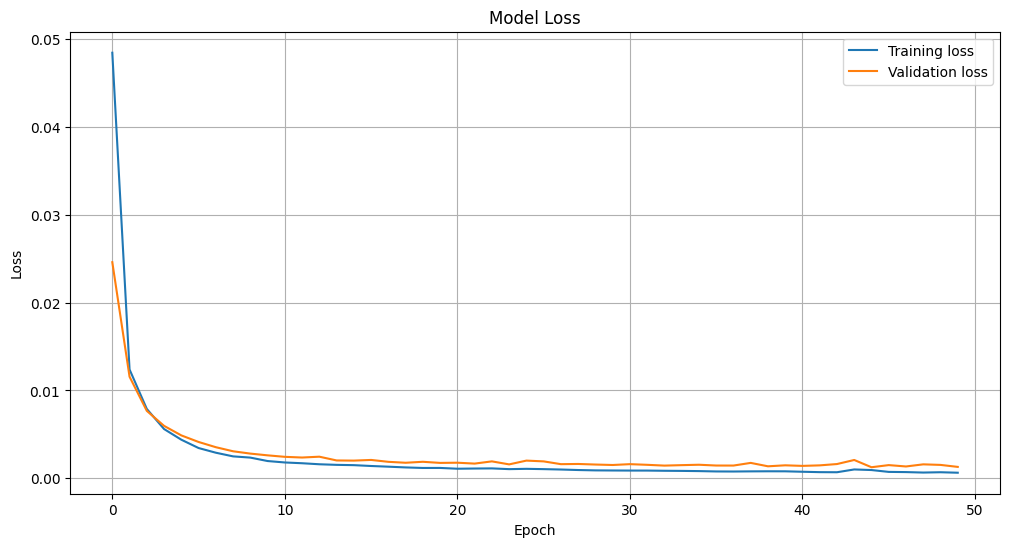

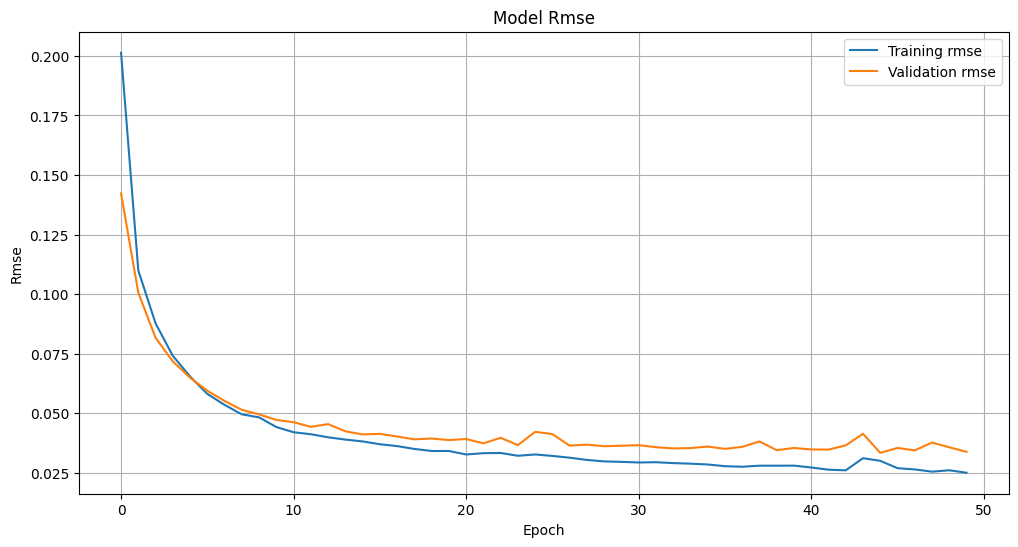

In [121]:
plot_history(best_history)